# Programing exercise 4: Collective Ising spins

Due on Monday, 19.11.2018, 14.15h

### Total: 100 points

## The problem

The collective Ising spin-model with a transverse field is governed by the Hamiltonian
$$
H=-\frac{J}{N}S_z^2 - \Omega S_x
$$
with the collective spin operators $S_\alpha = \sum_i \sigma_i^\alpha/2$, where $\sigma_i^\alpha$ is a Pauli operator acting on spin $i$. This model features a quantum phase transition at $\Omega/J=1$, meaning that the ground state propoerties change abruptly. It also shows a dynamical phase transition at $\Omega/J=0.5$, meaning that the long time properties of the dynamics change drastically at this point. The dynamical case was recently studied experimentally using a chain of trapped ions (https://www.nature.com/articles/nature24654). Note the different convention (x<>z) and the differences in the definition of field and interaction strength chosen there. Also, in the experiment the interactions where not strictly infinite range but powerlaw with a small exponent.

We want to use this model to see how phase transitions can be observed numerically by extrapolating to infinite $N$, and to see how symmetries can be exploited to greatly reduce the size of the relevant Hilbert space of a spin system.

In [12]:
# load standard libraries

import numpy as np   # standard numerics library
import numpy.linalg as LA
import scipy.linalg as sciLA

import matplotlib.pyplot as plt   # for making plots

import time as time
from ipywidgets import interactive # interactive
import scipy.sparse as sp
import scipy.sparse.linalg as sLA
from scipy.optimize import curve_fit

from IPython.display import display, Markdown #output

%matplotlib inline

### Exercise 1 (25 points)

We first want to study the low lying eigenstates and observe the quantum phase transition. Thus, it makes sense to work with sparse matrices.

Generate the Hamiltonian as a sparse matrix. You can proceed similarly to the coupled oscillator problem: Build the matrix representation of the collective spin operator $S_+$ and $S_z$, and then use these to construct any other operators you need, e.g. $S_x=(S_+ + S_-)/2$. For matrix-matrix and matrix-vector multiplication it is intuitive to use the @ operator in python 3, which is a short hand for the dot() function.

Test your implementation for N=20 with small and large values of $\Omega$ (set J=1 from now on, meaning that times are in units of 1/J and when we speak of $\Omega$ we really mean the dimensionless parameter $\Omega/J$). What do you expect for $S_z$ and $S_x$ in either limit? 

Collective Spin operator: $$S_a=\sum_{i=1}^N S_a^{(i)}=\sum_{i=1}^N \sigma_a^{(i)}/2$$ where $$\sigma_a^{(i)}=\mathbb 1 \otimes \dots \otimes \sigma_a \otimes \dots \otimes \mathbb 1$$ $\sigma_a$ at index $i$.

In [13]:
#in |J,M> basis:
def M(N): #returns [-J,...,J]
    return np.array([*range(-N//2,N//2+1)])+(.5 if N%2==1 else 0)
def Sz(N):
    return sp.diags(M(N),0,format='csc')
def Spm(N,plus=True):
    return sp.diags(np.sqrt(N/2*(N/2+1)-M(N)*(M(N)+1))[:N],-1 if plus else 1)
def Sx(N):
    return sp.diags([np.sqrt(N/2*(N/2+1)-M(N)*(M(N)+1))[:N]]*2,[-1,1],format='csc')/2

In [14]:
#Hamiltonian as sparse matrix:
def H(N,Om,J=1):
    #-J/N*S_z^2-Ω*S_x
    return -J/N*Sz(N)**2-Om*Sx(N)

Looking at extrem values for $ \Omega /J$, we can neglect a term. For small values, $\Omega<<J$, the $S_x$ term is left to fall out. Therefore our hamiltonian is basically the $S_z^2$ Operator. Looking at the other extrem, our Hamiltonian only consists of the $S_x$ matrix.

In [15]:
N=20
Om=0.01
Ham=H(N,Om)
w,v=sLA.eigsh(Ham,which='SA',k=5)
print(r"Eigenvalues for Omega= " +str(Om) +" "+str(w))
Om2=100
Ham2=H(N,Om2)
w2,v2=sLA.eigsh(Ham2,which='SA',k=5)
print(r"Eigenvalues for Omega= " +str(Om2)+" "+str(w2))

Eigenvalues for Omega= 0.01 [-5.00052632 -5.00052632 -4.05059134 -4.05059134 -3.20068237]
Eigenvalues for Omega= 100 [-1000.25059644  -900.72660957  -801.15228239  -701.52765322
  -601.85276026]


In the first case we created a Hamiltonian with a neglectable $S_x$ component. Thererfore our eigenvalues fully correspond to the $-\frac{J S_z^2}{N}$part. As our states are given in the $|J,M\rangle$ form, with $S_z|J,M\rangle=M|J,M\rangle$, our eigenvalues simply correspond to $-\frac{J M^2}{N}$. As $M\in[-N/2,..,N/2]$ we obtain for our theoretical eigenvalues in this case $10^2/20,9^2/20,8^2/20...$, which are exactly the numerical ones we obtained. 
The second case describes a system with a neglectable $S_Z^2$ component. Therefore only the $S_x$ eigenvalues matter. As it still describes a Spin, just in another direction, it is clear, that we will obtain the same eigenvalues for $S_x$ as with $S_z$, just in another basis. Therefore we obtain $\Omega \cdot [-10,-9,-8,..8,9,10]$ as our eigenvalues.

### Exercise 2 (20 points)

Loop over $\Omega$ (from 0 to 2 in small steps) and record the lowest 3 eigenenergies and, for the ground state, the probabilities P(M) to be in state $|N/2,M\rangle$. Plot the 3 lowest energy levels and P(M;$\Omega$) (density plot!). At small $\Omega$ you should observe kind of a "spontaneous symmetry breaking": The gap between ground and first excited state becomes very small. The states $|00...0\rangle = |N/2,N/2\rangle$ and $|11...1\rangle = |N/2,-N/2\rangle$ are degenerate ground states at a $\Omega=0$. The Hamiltonian has a $Z_2$ symmetry. It is invariant under flipping of all spins. Thus the eigenstates should also respect this symmetry and be either symmetric or anti-symmetric with respect to spin flips. However, when the gap between the symmetric and anti-symmetric state becomes too small, the numerical diagonalization algorithm just randomly choses a superposition of the two states, which can as well be $|N/2,-N/2\rangle$ or $|N/2,N/2\rangle$, thus breaking the symmetry.

The spin flip symmetry means that, if written in the symmetrized basis, the Hamiltonian will consist of two disconnected blocks, representing the symmetric ($\propto |N/2,M\rangle + |N/2,-M\rangle$) and anti-symmetric states ($\propto |N/2,M\rangle - |N/2,-M\rangle$). This means that the relevant gap we have to look at is the gap between lowest two states of one block. If we don't want to do the symmetrization explicitly, this can be done by just looking at the energy difference between the ground and the second excited state, which should be both symmetric.

[Optional]: One could also fix this by considering the symmetric and anti-symmetric blocks separately. For this you need to implement the Hamiltonian again in the symmetrized basis (or use a basis transformation into the symmetrized basis). This will give a speedup of at least a factor of 2.

In [16]:
OmSpace=np.linspace(0,2,100)
#OmSpace=[0.4]
EigEn=[]
probM=[]
N=20
for Om in OmSpace:
    Ham=H(N,Om)
    w,v=sLA.eigsh(Ham,which='SA',k=3)
    EigEn.append(w)
    row=[]
    for m in range(N+1):
        jm=np.zeros(N+1)
        jm[m]=1
        row.append(LA.norm(jm@v[:,0]))
    probM.append(row)
probM=np.array(probM)

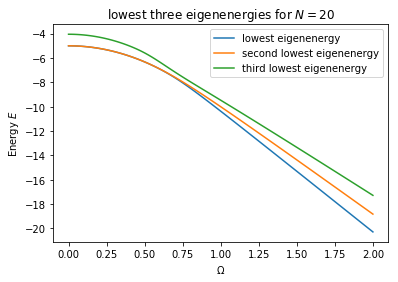

In [17]:
for i in range(3):
    plt.plot(OmSpace,np.transpose(EigEn)[i],label='%s'%(['','second ','third '][i])+'lowest eigenenergy')
plt.legend()
plt.xlabel('$\Omega$')
plt.ylabel('Energy $E$')
plt.title('lowest three eigenenergies for $N=%i$'%N)
plt.show()

As expected, we can see the symmetry breaking for small $\Omega$ leaving the two lowest eigenstates to merge.

Text(0.5,1,'Probability P(M;$\\Omega$)')

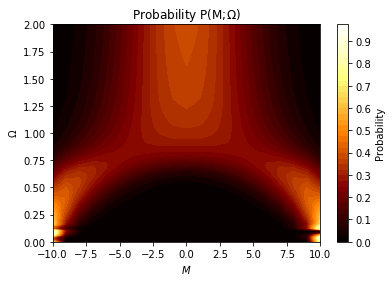

In [18]:
x,y=np.meshgrid(M(N),OmSpace)
plt.contourf(x,y,probM,40,cmap=plt.cm.afmhot)
plt.colorbar(label='Probability')
plt.xlabel('$M$')
plt.ylabel('$\Omega$')
plt.title('Probability P(M;$\Omega$)')

### Exercise 3 (20 points)

Loop over omega and go to large N to see how the gap ($E_2-E_0$) closes at the critical point ("finite size scaling analysis"). Extract the position and size of the smallest gap as a function of N. Loop N from 40 to 400 in steps of 20. The easiest way to get the minimal gap is to calculate it on an omega-gid around 1, where the transition is expected to be. I increased $\Omega$ from 0.8 to 1 in 100 steps. You could also make the search for the minimal gap more efficient by implementing an iterative search procedure.

Plot the resulting distance of the optimal $\Omega$ and size of the minimal gap double logarithmically. You should get a power law behavior. Extract the exponent of this power law for both quantities.

In [19]:
NSpace=np.array(range(40,401,20))
OmSpace=np.linspace(.8,1,100)
diff,pos=[],[]
for N in NSpace:
    row=[]
    for Om in OmSpace:
        Ham=H(N,Om)
        w,v=sLA.eigsh(Ham,which='SA',k=3)
        row.append(w[2]-w[0])
    diff.append(min(row))
    pos.append(np.argmin(row))

In [20]:
def logline(x,a,b):
    return a*x**b

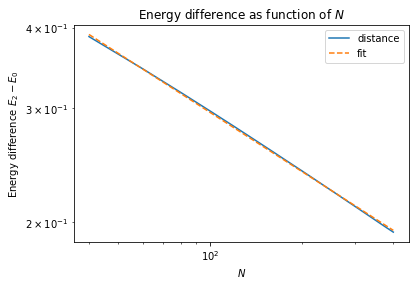

In [21]:
plt.loglog(NSpace,diff,label='distance')
popt,pcov=curve_fit(logline,NSpace,diff)
plt.plot(NSpace,logline(NSpace,*popt),'--',label='fit')
plt.legend()
plt.title('Energy difference as function of $N$')
plt.xlabel('$N$')
plt.ylabel('Energy difference $E_2-E_0$')
plt.show()

In [22]:
display(Markdown('The parameters of the power law $a\cdot x^b$ are $a=%.3f\pm %.2e, b=%.3f\pm %.2e$'%(popt[0],np.diag(pcov)[0],popt[1],np.diag(pcov)[1])))

The parameters of the power law $a\cdot x^b$ are $a=1.199\pm 7.80e-05, b=-0.304\pm 2.18e-06$

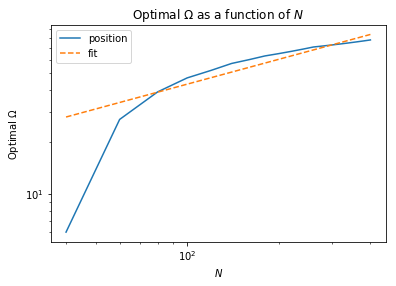

In [34]:
plt.loglog(NSpace,pos,label='position')
popt,pcov=curve_fit(logline,NSpace,pos)
plt.plot(NSpace,logline(NSpace,*popt),'--',label='fit')
plt.legend()
plt.title('Optimal $\Omega$ as a function of $N$')
plt.xlabel('$N$')
plt.ylabel('Optimal $\Omega$')
plt.show()

In [35]:
display(Markdown('The parameters of the power law $a\cdot x^b$ are $a=%.3f\pm %.2e, b=%.3f\pm %.2e$'%(popt[0],np.diag(pcov)[0],popt[1],np.diag(pcov)[1])))

The parameters of the power law $a\cdot x^b$ are $a=4.769\pm 2.02e+00, b=0.479\pm 2.89e-03$

### Exercise 4 (20 points)

Now calculate the time evolution under the above Hamiltonian, starting in the state $|00...0\rangle = |N/2,N/2\rangle$. For this, you could use scipy's expm function which allows you to simply exponentiate a matrix so you can directly calculate $exp(-iHt)$ and apply it to the initial state (e.g. using the @ operator). Try this out. You will see that it becomes really slow as you go to larger atom numbers. The more efficient way is to use exact diagonalization. This time the use of sparse matrices is not crucial since we need all the eigenstates anyway. Also, the spin flip symmetry is now not so useful since our initial state already breaks this symmetry. 

To calculate $|\psi(t)\rangle$, project the initial state onto the eigenstates. Remember that the eigenstates are in the columns of the eigenvector matrix returned by eig (or eigh). Thus the transformation into the energy eigenbasis can be achieved by applying the conjugate transpose of this matrix to the initial state. Evolve the state in the eigenbasis and transform back.

Calculate the expectation values of $S_z$ and $S_z^2$ as a function of time for some value of $\Omega$ below and above 0.5. You should see different behavior in the two regimes. Check whether your reults argee qualitatively with the observations in https://www.nature.com/articles/nature24654 in particular Fig. 2 (the paper is also on the arxiv at https://arxiv.org/abs/1708.01044). Note that their definition of the parameter $\Omega/J$ differs by a factor 1/2 from ours such that the transition point is at 1 for them.

In [24]:
def groundstate(N):
    start=np.zeros(N+1)
    start[-1]=1 #|N/2,N/2>
    return start

In [25]:
#try out scipy.linalg.expm
Ns=[2,5,10,50,100,200,300,400]
times=[None]*len(Ns)
for i in range(len(Ns)):
    N=Ns[i]
    start=np.zeros(N+1)
    start[-1]=1 #|N/2,N/2>
    print('N=%i:'%N)
    tem= %timeit -o start@sLA.expm(-1j*H(N,.6)*1) #t=1
    times[i]=tem.best
    print('-------------------------------------------')


N=2:
11.7 ms ± 876 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
-------------------------------------------
N=5:
15.5 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
-------------------------------------------
N=10:
20.5 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
-------------------------------------------
N=50:
52.1 ms ± 1.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
-------------------------------------------
N=100:
112 ms ± 3.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
-------------------------------------------
N=200:
676 ms ± 64.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
-------------------------------------------
N=300:
2.79 s ± 216 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
-------------------------------------------
N=400:
7.87 s ± 58.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
-------------------------------------------


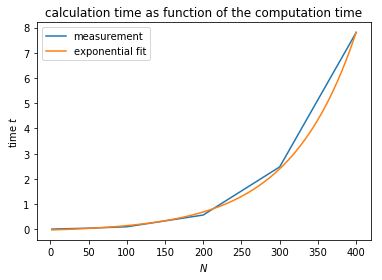

In [26]:
plt.plot(Ns,times,label='measurement')
def ex(x,a,b,c):
    return a*b**x+c
p,o=curve_fit(ex,Ns,times)
nlinsp=np.linspace(Ns[0],Ns[-1],1000)
plt.plot(nlinsp,ex(nlinsp,*p),label='exponential fit')
plt.title('calculation time as function of the computation time')
plt.xlabel('$N$')
plt.ylabel('time $t$')
plt.legend()
plt.show()

We can see that with the number of atoms the time evolution grows exponentially

In [27]:
#calculate eigenvectors of start state
N,Om=20,.4
start=groundstate(N)
w,v=LA.eig(H(N,Om).toarray())
#time evolution of the vector a 
def timeEvolEig(a,t,w,v):
    #change basis
    x=v.T@a
    #time evolution of each eigenstate
    xt=x*np.exp(-1j*w*t)
    #return to basis:
    return LA.inv(v.T)@xt

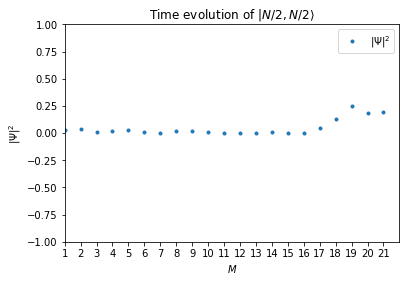

In [28]:
#animation of the time evolution of the start state
from matplotlib import animation
from IPython.display import HTML

fig, ax = plt.subplots()
# add axis specifications
line, = ax.plot([],[],'.',label='|$\Psi|^2$')
plt.ylim(-1,1)
plt.xlim(1,N+2)
plt.legend()
plt.xlabel('$M$')
plt.xticks(np.arange(1,N+2))
plt.ylabel('|$\Psi|^2$')
plt.title(r'Time evolution of $|N/2,N/2\rangle$')
def animate(t):
    line.set_data(np.arange(1,N+2),np.square(np.abs(timeEvolEig(start,t,w,v))))
    return (line,)

anim = animation.FuncAnimation(fig, animate,
                               frames=np.arange(0,10,.1), # t-values
                               interval=50, # wait time before displaying new frame in ms
                               blit=True)

HTML(anim.to_jshtml())

Expectation value: $$\langle S_z \rangle=\langle \psi(t) | S_z|\psi(t)\rangle$$

In [29]:
#expectation values for Sz and Sz^2:
def expectationValue(N,Om,operator,start,tSpace):
    expVal=[]
    w,v=LA.eig(H(N,Om).toarray())
    for t in tSpace:
        timeState=timeEvolEig(start,t,w,v)
        expVal.append(timeState.T.conj()@operator@timeState)
    return np.real(expVal) #if there is a complex part it is due to numerical inaccuracies

C:\Users\Tobias\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


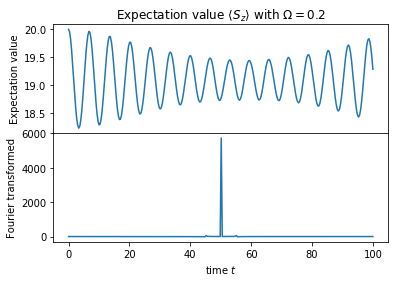

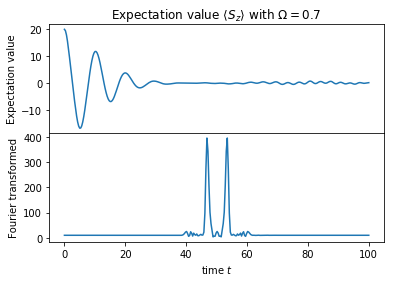

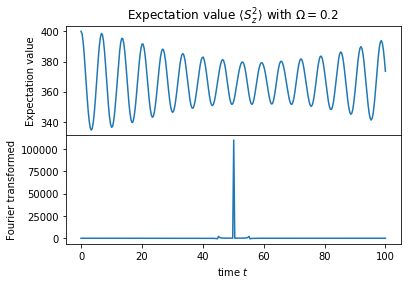

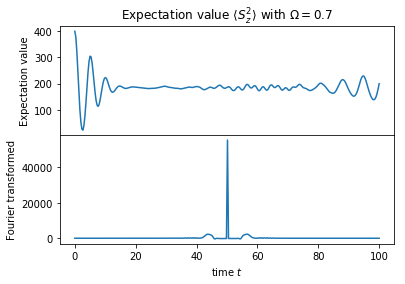

In [30]:
om=[.2,.7]
for i in range(2):
    for j in range(2):
        N=40
        start=groundstate(N)
        time=np.linspace(0,100,300)
        f, sub = plt.subplots(2, sharex=True)
        f.subplots_adjust(hspace=0)
        plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
        sub[0].set_title(r'Expectation value $\langle S_z%s \rangle$ with $\Omega=%.1f$'%(['','^2'][i],om[j]))
        sub[1].set_xlabel('time $t$')
        sub[0].set_ylabel('Expectation value')
        value=expectationValue(N,om[j],[Sz(N),Sz(N)**2][i],start,time)
        sub[0].plot(time,value)
        sub[1].plot(time,np.fft.fftshift(np.fft.fft(value)))
        sub[1].set_ylabel('Fourier transformed')

We can clearly see a difference between $\Omega > 0.5$ and $\Omega < 0.5$. For smaller $\Omega$'s the resulting expectation value is "cleaner" meaning the fourier transformation only has few discrete components.

### Exercise 5 (15 points)

Study the long-time limit systematically as a function of $\Omega$. Loop $\Omega$ from 0 to 1 in at least 50 steps. Use at least N=100. Calculate the values of $S_z$ and $S_z^2$ at some long time. Also calculate the infinite time average 
$$
\langle O \rangle_\infty = \sum_k |\langle \psi_0|\phi_k\rangle|^2 \langle \phi_k|O|\phi_k\rangle
$$
where $|\phi_k\rangle$ are the eigenstates and $O$ is the observables of interest (here $S_z$ or $S_z^2$).
Compare your results to Fig. 6 in https://arxiv.org/abs/1708.01044. This shows the dynmaical phase transition.

In [31]:
def longTimeLimit(N,Om,t,operator,start):
    w,v=LA.eig(H(N,Om).toarray())
    timeState=timeEvolEig(start,t,w,v)
    return np.real(timeState.T.conj()@operator@timeState) #if there is a complex part it is due to numerical inaccuracies

In [32]:
def expValInf(N,Om,operator,start):
    w,v=LA.eig(H(N,Om).toarray())
    OInf=0
    for i in range(N+1):
        OInf+=np.square(np.abs(start.T.conj()@v[:,i]))*v[:,i].T.conj()@operator@v[:,i]
    return OInf

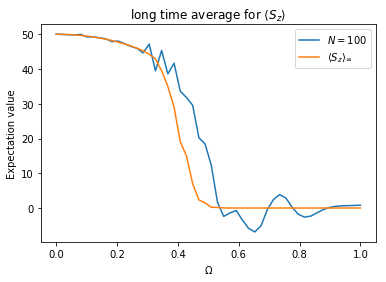

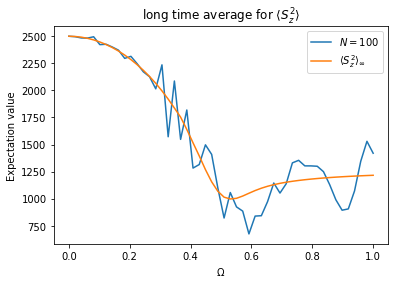

In [33]:
OmSpace=np.linspace(0,1,50)
N=100
op=[Sz(N),Sz(N)**2]
for i in range(2):
    plt.figure()
    expVal,expInf=[],[]
    for Om in OmSpace:
        expVal.append(longTimeLimit(N,Om,1e3,op[i],groundstate(N)))
        expInf.append(expValInf(N,Om,op[i],groundstate(N)))
    plt.plot(OmSpace,expVal,label='$N=%i$'%N)
    plt.title(r'long time average for $\langle S_z%s \rangle$'%(['','^2'][i]))
    plt.xlabel('$\Omega$')
    plt.ylabel('Expectation value')
    plt.plot(OmSpace,expInf,label=r'$\langle S_z%s \rangle_{\infty}$'%['','^2'][i])
    plt.legend()

The results are similar to those in the paper.